
==== DATA INFO ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  T

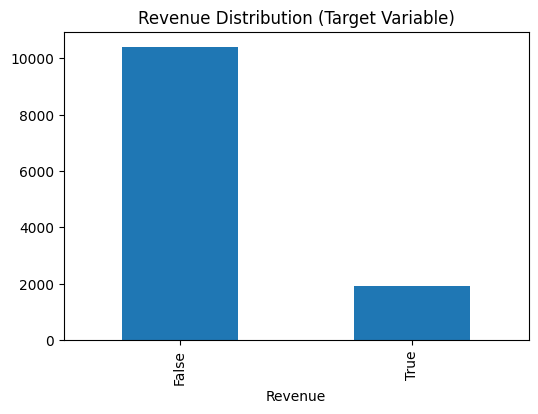

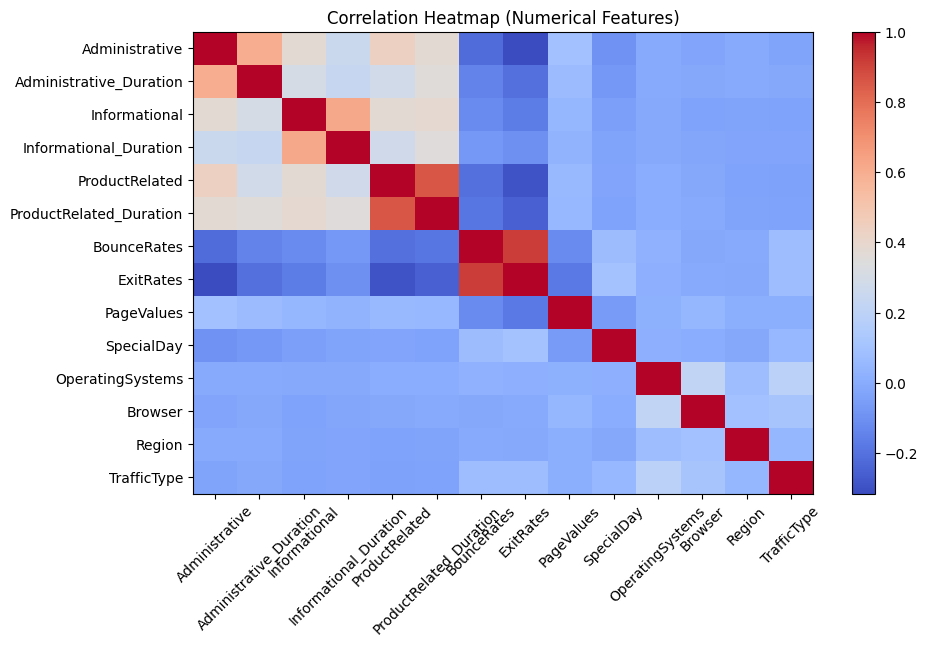


==== Categorical Correlation with Revenue (Cramér's V) ====
Month          0.176690
VisitorType    0.104735
Weekend        0.029030
dtype: float64


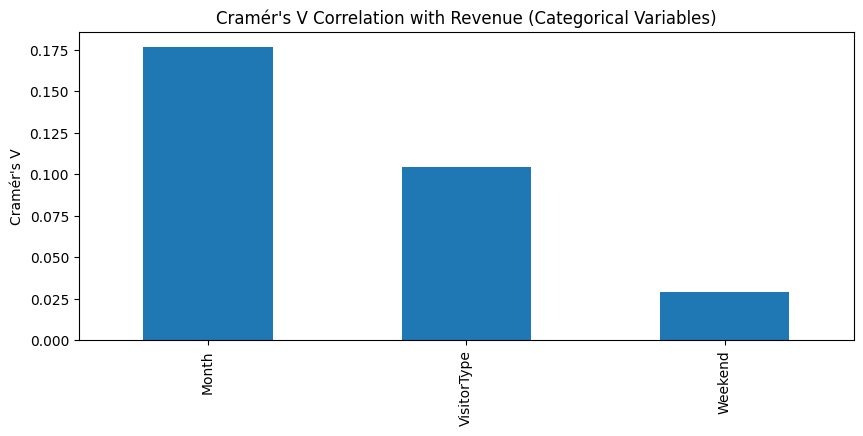


==== PROCESSED FEATURE SHAPE ====
(12330, 31)

==== TRAIN/TEST SPLIT ====
Train size: (9864, 31)  Test size: (2466, 31)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("data/online_shoppers_intention.csv")

# -----------------------------
# 1. Initial EDA
# -----------------------------
print("\n==== DATA INFO ====")
df.info()

print("\n==== MISSING VALUES ====")
print(df.isnull().sum())

print("\n==== TARGET DISTRIBUTION ====")
print(df['Revenue'].value_counts())

plt.figure(figsize=(6, 4))
df['Revenue'].value_counts().plot(kind='bar')
plt.title("Revenue Distribution (Target Variable)")
plt.show()

# -----------------------------
# 2. Numerical Correlation Matrix
# -----------------------------
numerical_feats = df.select_dtypes(include=['float64', 'int64'])
cor_matrix = numerical_feats.corr()

plt.figure(figsize=(10, 6))
plt.imshow(cor_matrix, cmap="coolwarm", aspect="auto")
plt.xticks(range(len(cor_matrix)), cor_matrix.columns, rotation=45)
plt.yticks(range(len(cor_matrix)), cor_matrix.columns)
plt.colorbar()
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# -----------------------------
# 3. Categorical Correlation (Cramér's V)
# -----------------------------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_feats = df.select_dtypes(include=['object', 'bool']).columns.drop('Revenue')

cat_corr = {col: cramers_v(df[col], df['Revenue']) for col in categorical_feats}
cat_corr = pd.Series(cat_corr).sort_values(ascending=False)

print("\n==== Categorical Correlation with Revenue (Cramér's V) ====")
print(cat_corr)

plt.figure(figsize=(10, 4))
cat_corr.plot(kind='bar')
plt.title("Cramér's V Correlation with Revenue (Categorical Variables)")
plt.ylabel("Cramér's V")
plt.show()

# -----------------------------
# 4. Feature Engineering
# -----------------------------
# Example: Extracting high season (e.g., Nov-Dec) from Month
df['Is_HighSeason'] = df['Month'].isin(['Nov', 'Dec'])

# One-Hot Encoding, Scaling
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

X_processed = pipeline.fit_transform(X)

print("\n==== PROCESSED FEATURE SHAPE ====")
print(X_processed.shape)

# -----------------------------
# 5. (Optional) Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print("\n==== TRAIN/TEST SPLIT ====")
print("Train size:", X_train.shape, " Test size:", X_test.shape)
